Showing the training data


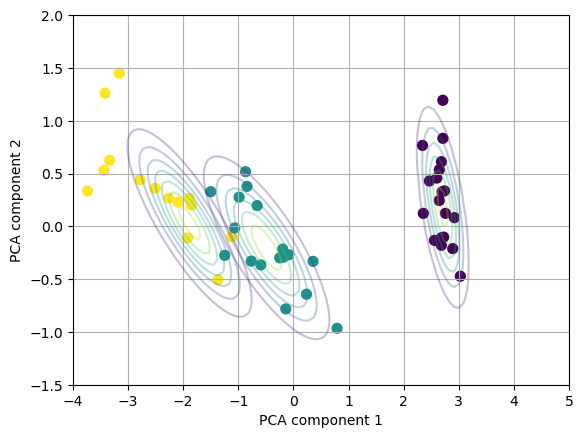

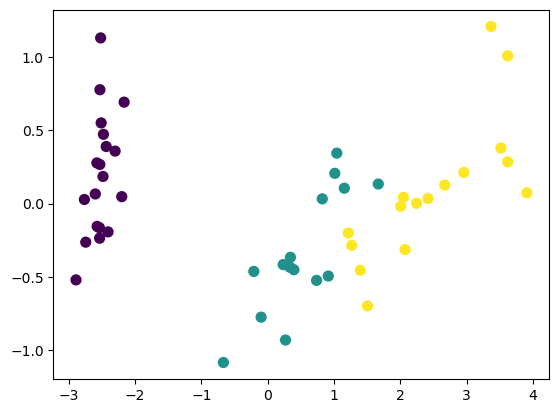

Classification accuracy:  0.96


In [14]:
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
import scipy.special




def load_iris():
    D,L = sklearn.datasets.load_iris()['data'].T, sklearn.datasets.load_iris()['target']
    return D, L

D, L = load_iris()

def split_train(D, L, percentageTraining, seed=0):
    nTrain = int(D.shape[1] * percentageTraining)
    np.random.seed(seed)
    shuffledIndices = np.random.permutation(D.shape[1])

    DTR = D[:, shuffledIndices[0:nTrain]]
    LTR = L[shuffledIndices[0:nTrain]]

    DVAL = D[:, shuffledIndices[nTrain:]]
    LVAL = L[shuffledIndices[nTrain:]]

    return (DTR, LTR), (DVAL, LVAL)



def calc_params(D):
    U = D.mean(axis=1, keepdims=True)
    z = D - U
    C = z @ z.T / D.shape[1]

    return U, C


def logpdf_GAU_ND(X, mu, C):
    """
    Calculates the log of the probability density function of a multivariate Gaussian distribution.
    """
    _, C_logdet = np.linalg.slogdet(C)
    C_inv = np.linalg.inv(C)
    dotp = 0.5 * np.sum((X - mu) * (C_inv @ (X - mu)), axis=0)

    return -C.shape[0]/2 * np.log(2*np.pi) - 0.5 * C_logdet - dotp

def analyze_2D(DTR, LTR, DVAL, LVAL, params_func = None):
    pca = PCA(n_components=2)
    pcafit = pca.fit(DTR.T)
    DTRPCA = pcafit.transform(DTR.T).T
    DVALPCA = pcafit.transform(DVAL.T).T

    x = np.linspace(-4, 5, 100)
    y = np.linspace(-1.5, 2.0, 100)
    X, Y = np.meshgrid(x, y)
    grid = np.array([X.ravel(), Y.ravel()])


    if params_func is None:
        params_by_class = [calc_params(DTRPCA[:, (LTR == l)]) for l in np.unique(LTR)]
    else:
        params_by_class = params_func(DTRPCA, LTR)
        print("params_by_class", params_by_class)

    plt.figure()

    for i, params in enumerate(params_by_class):
        Z = np.exp(logpdf_GAU_ND(grid, params[0], params[1]))
        Z = Z.reshape(X.shape)
        CS = plt.contour(X, Y, Z, alpha=0.3)


    plt.scatter(DVALPCA[0,:], DVALPCA[1,:], c=LVAL, s=50)
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.grid()


def vcol(x):
    return x.reshape(-1, 1)
def vrow(x):
    return x.reshape(1, -1)

def classify_pdf(D, L):
    (DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0, seed=0)
    def params_func(DTR, LTR):
        return [calc_params(DTR[:, (LTR == l)]) for l in np.unique(LTR)]
    params_by_class = params_func(DTR, LTR)
    Pc = 1/3
    SJoint = np.array([np.exp(logpdf_GAU_ND(DVAL, params[0], params[1])) * Pc for params in params_by_class])

    SMarginal = vrow(SJoint.sum(0))
    SPost = SJoint / SMarginal

    predicted = np.argmax(SPost, axis=0)
    analyze_2D(DTR, LTR, DVAL, LVAL)

    pca = PCA(n_components=2)
    DVALPCA = pca.fit_transform(DVAL.T).T

    plt.figure()
    plt.scatter(DVALPCA[0,:], DVALPCA[1,:], c=predicted, s=50)
    plt.show()

    # Model evaluation
    print("Classification accuracy: ", np.mean(predicted == LVAL))



print("Showing the training data")
classify_pdf(D, L)


params_by_class [(array([[2.71024557],
       [0.17982309]]), array([[ 0.05814757, -0.06801106],
       [-0.06801106,  0.24262623]])), (array([[-0.48833063],
       [-0.20316242]]), array([[ 0.34018916, -0.20543368],
       [-0.20543368,  0.19690137]])), (array([[-1.88618616],
       [ 0.03138456]]), array([[ 0.31552313, -0.20454166],
       [-0.20454166,  0.19657381]]))]


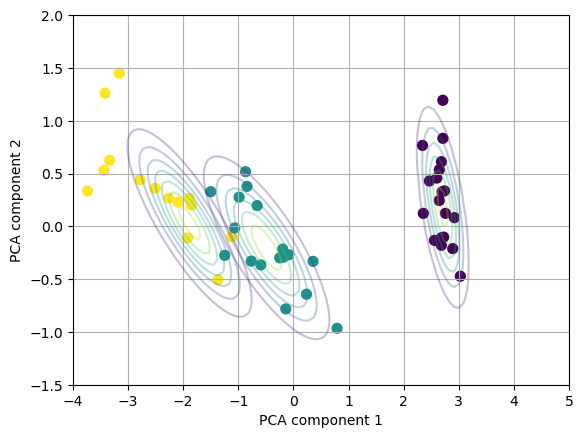

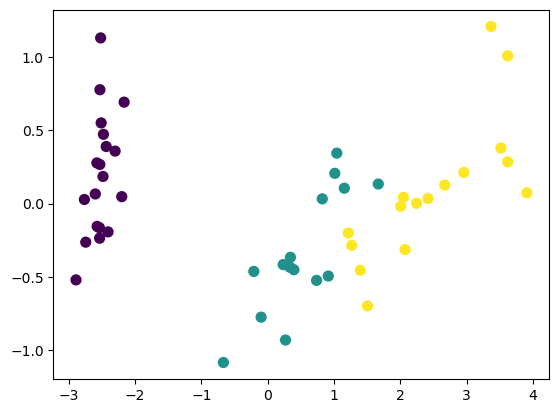

Classification accuracy:  0.96


In [15]:

def classify_log_pdf(D, L):
    (DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0, seed=0)

    def params_func(DTR, LTR):
        return [calc_params(DTR[:, (LTR == l)]) for l in np.unique(LTR)]
    params_by_class = params_func(DTR, LTR)
    Pc = 1/3
    logSJoint = np.array([logpdf_GAU_ND(DVAL, params[0], params[1]) + np.log(Pc) for params in params_by_class])

    logSMarginal = scipy.special.logsumexp(logSJoint, axis=0).reshape(1, -1)
    logSPost = logSJoint - logSMarginal

    predicted = np.argmax(np.exp(logSPost), axis=0)
    analyze_2D(DTR, LTR, DVAL, LVAL, params_func)

    pca = PCA(n_components=2)
    DVALPCA = pca.fit_transform(DVAL.T).T

    plt.figure()
    plt.scatter(DVALPCA[0,:], DVALPCA[1,:], c=predicted, s=50)
    plt.show()

    # Model evaluation
    print("Classification accuracy: ", np.mean(predicted == LVAL))

classify_log_pdf(D, L)

params_by_class [(array([[2.71024557],
       [0.17982309]]), array([[ 0.05814757, -0.        ],
       [-0.        ,  0.24262623]])), (array([[-0.48833063],
       [-0.20316242]]), array([[ 0.34018916, -0.        ],
       [-0.        ,  0.19690137]])), (array([[-1.88618616],
       [ 0.03138456]]), array([[ 0.31552313, -0.        ],
       [-0.        ,  0.19657381]]))]


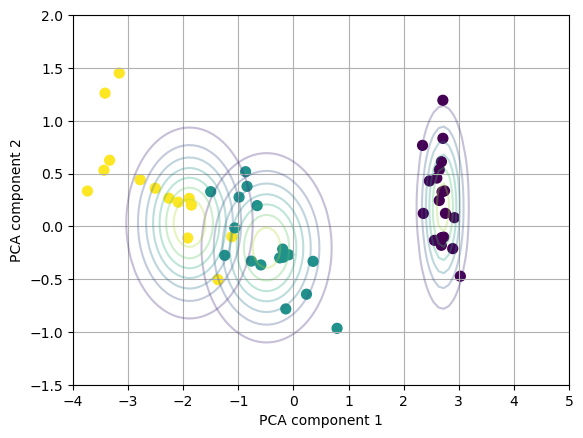

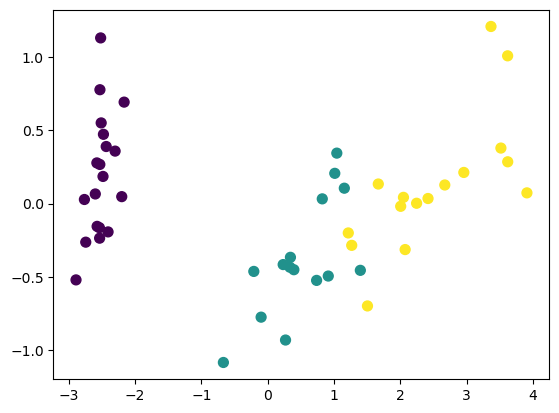

Classification accuracy:  0.96


In [16]:
def calc_params_naive(D):
    U = D.mean(axis=1, keepdims=True)
    z = D - U
    C = z @ z.T / D.shape[1]

    return U, C * np.eye(C.shape[0])

def classify_log_pdf_naive(D, L):
    (DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0, seed=0)
    def params_func(DTR, LTR):
        return [calc_params_naive(DTR[:, (LTR == l)]) for l in np.unique(LTR)]

    params_by_class = params_func(DTR, LTR)
    Pc = 1/3
    logSJoint = np.array([logpdf_GAU_ND(DVAL, params[0], params[1]) + np.log(Pc) for params in params_by_class])

    logSMarginal = scipy.special.logsumexp(logSJoint, axis=0).reshape(1, -1)
    logSPost = logSJoint - logSMarginal

    predicted = np.argmax(np.exp(logSPost), axis=0)
    analyze_2D(DTR, LTR, DVAL, LVAL, params_func)

    pca = PCA(n_components=2)
    DVALPCA = pca.fit_transform(DVAL.T).T

    plt.figure()
    plt.scatter(DVALPCA[0,:], DVALPCA[1,:], c=predicted, s=50)
    plt.show()

    # Model evaluation
    print("Classification accuracy: ", np.mean(predicted == LVAL))

classify_log_pdf_naive(D, L)



params_by_class [(array([[2.71024557],
       [0.17982309]]), array([[ 0.2438765 , -0.16251154],
       [-0.16251154,  0.21095815]])), (array([[-0.48833063],
       [-0.20316242]]), array([[ 0.2438765 , -0.16251154],
       [-0.16251154,  0.21095815]])), (array([[-1.88618616],
       [ 0.03138456]]), array([[ 0.2438765 , -0.16251154],
       [-0.16251154,  0.21095815]]))]


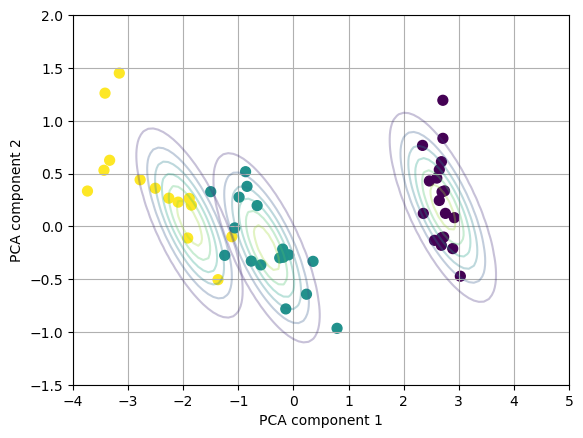

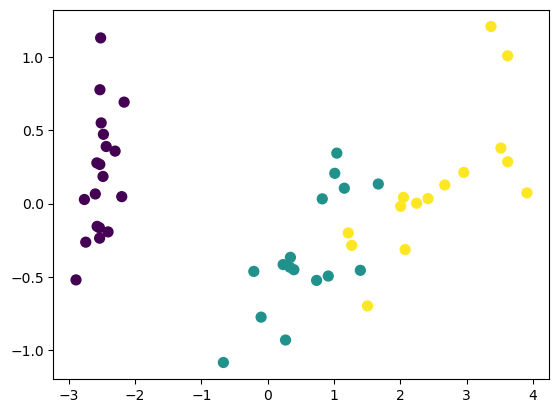

Classification accuracy:  0.98


In [17]:
def classify_log_pdf_tied(D, L):
    (DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0, seed=0)

    def params_func(DTR, LTR):
        params_by_class = []
        C_tied = np.zeros((DTR.shape[0], DTR.shape[0]))
        for l in np.unique(LTR):
            Dl = DTR[:, (LTR == l)]
            U = Dl.mean(axis=1, keepdims=True)
            z = Dl - U
            C_tied += z @ z.T
            params_by_class.append((U, 0))
        C_tied = C_tied / DTR.shape[1]
        for l in range(len(params_by_class)):
            params_by_class[l] = (params_by_class[l][0], C_tied)
        return params_by_class
    params_by_class = params_func(DTR, LTR)

    Pc = 1/3
    logSJoint = np.array([logpdf_GAU_ND(DVAL, params[0], params[1]) + np.log(Pc) for params in params_by_class])

    logSMarginal = scipy.special.logsumexp(logSJoint, axis=0).reshape(1, -1)
    logSPost = logSJoint - logSMarginal

    predicted = np.argmax(np.exp(logSPost), axis=0)
    analyze_2D(DTR, LTR, DVAL, LVAL, params_func)

    pca = PCA(n_components=2)
    DVALPCA = pca.fit_transform(DVAL.T).T

    plt.figure()
    plt.scatter(DVALPCA[0,:], DVALPCA[1,:], c=predicted, s=50)
    plt.show()

    # Model evaluation
    print("Classification accuracy: ", np.mean(predicted == LVAL))

classify_log_pdf_tied(D, L)


In [ ]:
def calc_llr(D, L):
    D = D[:, L != 0]
    L = L[L != 0]

    (DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0, seed=0)

    versicolor_params = calc_params(DTR[:, (LTR == 1)])
    virginica_params = calc_params(DTR[:, (LTR == 2)])

    s = logpdf_GAU_ND(DVAL, virginica_params[0], virginica_params[1]) - logpdf_GAU_ND(DVAL, versicolor_params[0], versicolor_params[1])
    print(s)

    # Load llr_MVG.npy
    llr_MVG = np.load("llr_MVG.npy")
    print("llr_MVG", llr_MVG)

    t = -np.log(1/2/(1/2))

    error_rate = np.mean((s > t) != (LVAL == 2))
    print("Error rate: ", error_rate)

calc_llr(D, L)

[-11.56868085   5.85068743 -11.27235327   8.21028284 -11.01737549
 -16.33634695  -8.67467942   6.90202853  15.21682395   0.87635727
   1.18539976  22.67868915  13.06138218   2.08227323 -10.22051843
  -7.65723886  -0.57149325  -8.43768434  -7.40963963  17.17228825
   7.34056812 -12.03802057   2.31541895  14.19332118   2.37238573
  -7.75569685 -11.28128524  -1.31763964  -4.9011698    7.09557504
   3.69406061  28.94502635  -9.94233154  -7.10623745]
llr_MVG [-11.56868085   5.85068743 -11.27235327   8.21028284 -11.01737549
 -16.33634695  -8.67467942   6.90202853  15.21682395   0.87635727
   1.18539976  22.67868915  13.06138218   2.08227323 -10.22051843
  -7.65723886  -0.57149325  -8.43768434  -7.40963963  17.17228825
   7.34056812 -12.03802057   2.31541895  14.19332118   2.37238573
  -7.75569685 -11.28128524  -1.31763964  -4.9011698    7.09557504
   3.69406061  28.94502635  -9.94233154  -7.10623745]
Error rate:  0.08823529411764706
